## 1. 데이터 준비

### 학습/테스트 데이터 준비

In [1]:
%mkdir data
%cd data
!wget https://github.com/e9t/nsmc/raw/master/ratings.txt
!wget https://github.com/e9t/nsmc/raw/master/ratings_train.txt
!wget https://github.com/e9t/nsmc/raw/master/ratings_test.txt
# !wget https://github.com/jungyeul/korean-parallel-corpora/raw/master/korean-english-news-v1/korean-english-park.train.tar.gz
# !tar -xzvf korean-english-park.train.tar.gz
%ls

/content/data
--2021-09-29 22:42:54--  https://github.com/e9t/nsmc/raw/master/ratings.txt
Resolving github.com (github.com)... 192.30.255.113
Connecting to github.com (github.com)|192.30.255.113|:443... connected.
HTTP request sent, awaiting response... 302 Found
Location: https://raw.githubusercontent.com/e9t/nsmc/master/ratings.txt [following]
--2021-09-29 22:42:54--  https://raw.githubusercontent.com/e9t/nsmc/master/ratings.txt
Resolving raw.githubusercontent.com (raw.githubusercontent.com)... 185.199.108.133, 185.199.109.133, 185.199.110.133, ...
Connecting to raw.githubusercontent.com (raw.githubusercontent.com)|185.199.108.133|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 19515078 (19M) [text/plain]
Saving to: ‘ratings.txt’

ratings.txt         100%[===================>]  18.61M  --.-KB/s    in 0.1s    

2021-09-29 22:42:55 (165 MB/s) - ‘ratings.txt’ saved [19515078/19515078]

--2021-09-29 22:42:55--  https://github.com/e9t/nsmc/raw/master/ratings_trai

### konlpy 설치

In [2]:
!sudo apt-get install g++ openjdk-8-jdk
!bash <(curl -s https://raw.githubusercontent.com/konlpy/konlpy/master/scripts/mecab.sh)
!pip install konlpy

Reading package lists... Done
Building dependency tree       
Reading state information... Done
g++ is already the newest version (4:7.4.0-1ubuntu2.3).
g++ set to manually installed.
The following additional packages will be installed:
  fonts-dejavu-core fonts-dejavu-extra libatk-wrapper-java
  libatk-wrapper-java-jni libgail-common libgail18 libgtk2.0-0 libgtk2.0-bin
  libgtk2.0-common libxxf86dga1 openjdk-8-jdk-headless openjdk-8-jre
  openjdk-8-jre-headless x11-utils
Suggested packages:
  gvfs openjdk-8-demo openjdk-8-source visualvm icedtea-8-plugin libnss-mdns
  fonts-ipafont-gothic fonts-ipafont-mincho fonts-wqy-microhei
  fonts-wqy-zenhei fonts-indic mesa-utils
The following NEW packages will be installed:
  fonts-dejavu-core fonts-dejavu-extra libatk-wrapper-java
  libatk-wrapper-java-jni libgail-common libgail18 libgtk2.0-0 libgtk2.0-bin
  libgtk2.0-common libxxf86dga1 openjdk-8-jdk openjdk-8-jdk-headless
  openjdk-8-jre openjdk-8-jre-headless x11-utils
0 upgraded, 15 newly i

## 2. 말뭉치 준비

In [3]:
import os 

import re

import tensorflow as tf
import numpy as np
import pandas as pd

import matplotlib.pyplot as plt
import seaborn as sns

In [4]:
corpus_data_path = "/content/data/ratings.txt"
df = pd.read_csv(corpus_data_path, sep="\t")
df.head()
print(len(df))

200000


In [5]:
print("== empty value ==")
print(df.isna().sum())
print()
print("== duplicated value ==")
print(len(df[df.duplicated(["document"])]))
print()


== empty value ==
id          0
document    8
label       0
dtype: int64

== duplicated value ==
5456



In [6]:
df = df.dropna()
df = df[~df.duplicated(["document"])]
len(df)

194543

In [7]:
df[~df['document'].str.contains(r"[a-zA-Z가-힣]", regex=True)]

,id,document,label
111,6906147,ㅎㅎㅎㅎㅎㅎㅎㅎ,1
190,7059515,ㅇㅋㅇㅋ,1
1199,7887700,♥♥,1
1301,7958033,ㅎㅎ,1
1346,9317820,1236547890,1
...,...,...,...
196902,135627,ㅇㅂㅀ,0
198364,7813772,??????????????????????????????????????????????...,0
199271,4852134,.............................,0
199321,4602734,2,0


In [8]:
df = df[df['document'].str.contains(r"[a-zA-Z가-힣]", regex=True)]

count    194146.000000
mean         36.094614
std          29.494785
min           1.000000
25%          16.000000
50%          27.000000
75%          43.000000
max         142.000000
Name: document_length, dtype: float64


/usr/local/lib/python3.7/dist-packages/seaborn/_decorators.py:43: FutureWarning: Pass the following variable as a keyword arg: x. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.
  FutureWarning


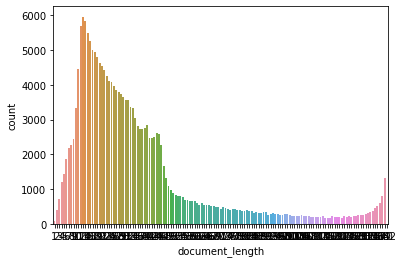

In [9]:
df["document_length"] = df['document'].map(lambda x: len(x))
print(df['document_length'].describe())

sns.countplot(df['document_length'])
plt.show()

In [10]:
df[df["document_length"]==1 & ~df['document'].str.contains(r"[가-힣]", regex=True)]

,id,document,label,document_length
2604,6876426,O,1,1
5082,1426659,g,1,1
13583,6898989,b,1,1
26608,404477,a,1,1
27894,7904933,d,1,1
28399,7516850,f,1,1
46336,444938,k,1,1
53260,7690744,z,1,1
66038,168734,h,1,1
167431,7077369,c,0,1


In [11]:
df = df[~(df["document_length"]==1 & ~df['document'].str.contains(r"[가-힣]", regex=True))]
len(df)

194136

In [12]:
corpus = df["document"].to_list()
corpus[:5]

['어릴때보고 지금다시봐도 재밌어요ㅋㅋ',
 '디자인을 배우는 학생으로, 외국디자이너와 그들이 일군 전통을 통해 발전해가는 문화산업이 부러웠는데. 사실 우리나라에서도 그 어려운시절에 끝까지 열정을 지킨 노라노 같은 전통이있어 저와 같은 사람들이 꿈을 꾸고 이뤄나갈 수 있다는 것에 감사합니다.',
 '폴리스스토리 시리즈는 1부터 뉴까지 버릴께 하나도 없음.. 최고.',
 '와.. 연기가 진짜 개쩔구나.. 지루할거라고 생각했는데 몰입해서 봤다.. 그래 이런게 진짜 영화지',
 '안개 자욱한 밤하늘에 떠 있는 초승달 같은 영화.']

## 2. sentencepiece

### sentence piece 설치

In [13]:
!pip install sentencepiece

     |████████████████████████████████| 1.2 MB 9.7 MB/s 


### corpus 준비

In [14]:
from konlpy.tag import Mecab
import sentencepiece as spm

In [15]:
def train_sentence_piece(corpus, model_type, vocab_size, temp_file_path):
  with open(temp_file, 'w') as f:
    for row in corpus:   # 이전 스텝에서 정제했던 corpus를 활용합니다.
      f.write(str(row) + '\n')

  spm.SentencePieceTrainer.Train(
      '--input={} --model_prefix=korean_spm --model_type={} --vocab_size={}'.format(temp_file_path, model_type, vocab_size)    
  )

In [16]:
temp_file = 'korean-english-park.train.ko.temp'

vocab_size = 10000
train_sentence_piece(corpus, "unigram", vocab_size, temp_file)

!ls -l korean_spm*

-rw-r--r-- 1 root root 413824 Sep 29 22:46 korean_spm.model
-rw-r--r-- 1 root root 185130 Sep 29 22:46 korean_spm.vocab


## 데이터 준비

In [17]:
def preprocess(df):
  df = df.dropna()
  df = df.drop_duplicates(["document"])
  df = df[df['document'].str.contains(r"[a-zA-Z가-힣]", regex=True)]
  df["document_length"] = df['document'].map(lambda x: len(x))
  df = df[~(df["document_length"]==1 & ~df['document'].str.contains(r"[가-힣]", regex=True))]
  df = df.drop(["document_length"], axis=1)
  return df

In [18]:
def load_sentence_piece():
  s = spm.SentencePieceProcessor()
  s.Load('korean_spm.model')
  return s

In [19]:
def load_data(s):
  print("data loading from file..")

  train_data_path = "/content/data/ratings_train.txt"
  test_data_path = "/content/data/ratings_test.txt"

  train_data = pd.read_csv(train_data_path, sep="\t")
  test_data = pd.read_csv(test_data_path, sep="\t")
  print( f'original train_data:{len(train_data)}, test_data:{len(test_data)}' )
  train_data = preprocess(train_data)
  test_data = preprocess(test_data)
  print( f'cleaned train_data:{len(train_data)}, test_data:{len(test_data)}' )

  X_train = train_data["document"]
  y_train = train_data["label"]
  X_test = test_data["document"]
  y_test = test_data["label"]

  print("\nSuccess!")
  print(f"Train data sample : [{y_train[100]}] {X_train[100]}")
  print(f"Test data sample : [{y_test[100]}] {X_test[100]}")

  print("\nencoding..")
  X_train, word_index, index_word = sp_tokenize(s, X_train)
  X_test, _, _ = sp_tokenize(s, X_test)
  print(f"Train data sample : [{y_train[100]}]\n\t{X_train[100].tolist()}\n\t{s.DecodeIds(X_train[100].tolist())}")
  print(f"Test data sample : [{y_test[100]}]\n\t{X_test[100].tolist()}\n\t{s.DecodeIds(X_test[100].tolist())}")

  return X_train, y_train, X_test, y_test, word_index, index_word


In [20]:
def sp_tokenize(s, corpus):

  tensor = []

  for sen in corpus:
    tensor.append(s.EncodeAsIds(sen))

  with open("./korean_spm.vocab", 'r') as f:
    vocab=f.readlines()

  word_index = {}
  index_word = {}

  for idx, line in enumerate(vocab):
    word = line.split("\t")[0]

    word_index.update({idx:word})
    index_word.update({word:idx})

  tensor = tf.keras.preprocessing.sequence.pad_sequences(tensor, padding='post', maxlen=100)

  return tensor, word_index, index_word


In [21]:
s = load_sentence_piece()

In [22]:
X_train, y_train, X_test, y_test, word_index, index_word = load_data(s)

data loading from file..
original train_data:150000, test_data:50000
cleaned train_data:145860, test_data:48997

Success!
Train data sample : [1] 신카이 마코토의 작화와,미유와 하나카나가 연기를 잘해줘서 더대박이였다.
Test data sample : [0] 걸작은 몇안되고 졸작들만 넘쳐난다.

encoding..
Train data sample : [1]
	[410, 489, 6, 350, 668, 577, 9, 6606, 50, 13, 124, 294, 50, 219, 489, 30, 10, 1017, 43, 6658, 54, 1577, 3651, 3, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0]
	신카이 마코토의 작화와,미유와 하나카나가 연기를 잘해줘서 더대박이였다. ⁇  ⁇  ⁇  ⁇  ⁇  ⁇  ⁇  ⁇  ⁇  ⁇  ⁇  ⁇  ⁇  ⁇  ⁇  ⁇  ⁇  ⁇  ⁇  ⁇  ⁇  ⁇  ⁇  ⁇  ⁇  ⁇  ⁇  ⁇  ⁇  ⁇  ⁇  ⁇  ⁇  ⁇  ⁇  ⁇  ⁇  ⁇  ⁇  ⁇  ⁇  ⁇  ⁇  ⁇  ⁇  ⁇  ⁇  ⁇  ⁇  ⁇  ⁇  ⁇  ⁇  ⁇  ⁇  ⁇  ⁇  ⁇  ⁇  ⁇  ⁇  ⁇  ⁇  ⁇  ⁇  ⁇  ⁇  ⁇  ⁇  ⁇  ⁇  ⁇  ⁇  ⁇  ⁇  ⁇ 
Test data sample : [0]
	[1032, 17, 617, 6516, 743, 3219, 7499, 911, 3, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,

In [23]:
word_index[2082], index_word["감동"]

('▁짜증나', 739)

## 모델 학습

In [24]:
from sklearn.model_selection import train_test_split

X_train, X_val, y_train, y_val = train_test_split(X_train, y_train, test_size=0.2)
print( f'train_data:{len(X_train)}, val_data:{len(X_val)}, test_data:{len(X_test)}' )

train_data:116688, val_data:29172, test_data:48997


In [25]:
def draw_history(history):
  history_dict = history.history
  acc = history_dict['accuracy']
  val_acc = history_dict['val_accuracy']
  loss = history_dict['loss']
  val_loss = history_dict['val_loss']

  epochs = range(1, len(acc) + 1)

  plt.figure(figsize=(8, 4))
  plt.subplot(1, 2, 1)
  plt.plot(epochs, acc, label='Accuracy')
  plt.plot(epochs, val_acc, 'red', label='Val_Accuracy')
  plt.legend(loc='lower right')
  plt.title('Accuracy')
  plt.xlabel('Epochs')
  plt.ylabel('Accuracy')

  plt.subplot(1, 2, 2)
  plt.plot(epochs, loss, label='Loss')
  plt.plot(epochs, val_loss, 'red', label='Val_Loss')
  plt.legend(loc='upper right')
  plt.title('Loss')
  plt.xlabel('Epochs')
  plt.ylabel('Loss')
  plt.show()

In [26]:
from tensorflow import keras

word_vector_dim = 256

model = keras.Sequential()
model.add(keras.layers.Embedding(vocab_size, word_vector_dim, input_shape=(None,)))
model.add(keras.layers.LSTM(8))
model.add(keras.layers.Dense(8, activation='relu'))
model.add(keras.layers.Dense(1, activation='sigmoid'))

model.summary()

Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
embedding (Embedding)        (None, None, 256)         2560000   
_________________________________________________________________
lstm (LSTM)                  (None, 8)                 8480      
_________________________________________________________________
dense (Dense)                (None, 8)                 72        
_________________________________________________________________
dense_1 (Dense)              (None, 1)                 9         
Total params: 2,568,561
Trainable params: 2,568,561
Non-trainable params: 0
_________________________________________________________________


In [27]:

ckpt_path = "checkpoint.ckpt"
checkpoint = keras.callbacks.ModelCheckpoint(ckpt_path, monitor="val_loss", save_weights_only=True, save_best_only=True, vervose=1)

In [28]:
model.compile(optimizer='adam',
             loss='binary_crossentropy',
             metrics=['accuracy'])

epochs=200

history = model.fit(X_train,
                   y_train,
                   epochs=epochs,
                   batch_size=512,
                   validation_data=(X_val, y_val),
                   verbose=1,
                   callbacks=[checkpoint])

Epoch 1/200
228/228 [==============================] - 9s 17ms/step - loss: 0.6932 - accuracy: 0.5001 - val_loss: 0.6932 - val_accuracy: 0.4940
Epoch 2/200
228/228 [==============================] - 4s 16ms/step - loss: 0.6932 - accuracy: 0.5013 - val_loss: 0.6931 - val_accuracy: 0.5060
Epoch 3/200
228/228 [==============================] - 4s 16ms/step - loss: 0.6932 - accuracy: 0.4991 - val_loss: 0.6932 - val_accuracy: 0.4941
Epoch 4/200
228/228 [==============================] - 4s 16ms/step - loss: 0.6932 - accuracy: 0.4987 - val_loss: 0.6931 - val_accuracy: 0.5059
Epoch 5/200
228/228 [==============================] - 4s 16ms/step - loss: 0.6931 - accuracy: 0.5024 - val_loss: 0.6931 - val_accuracy: 0.5059
Epoch 6/200
228/228 [==============================] - 4s 16ms/step - loss: 0.6931 - accuracy: 0.4974 - val_loss: 0.6931 - val_accuracy: 0.5060
Epoch 7/200
228/228 [==============================] - 4s 16ms/step - loss: 0.6931 - accuracy: 0.4994 - val_loss: 0.6931 - val_accuracy:

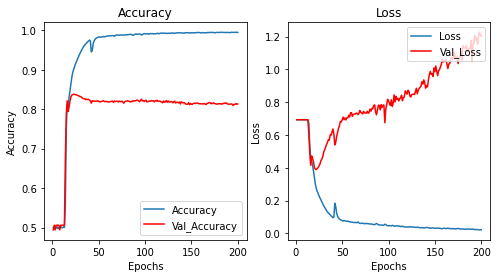

In [29]:
draw_history(history)

In [30]:
model.load_weights(ckpt_path)
results = model.evaluate(X_test,  y_test, verbose=2)
print(results)

1532/1532 - 4s - loss: 0.3913 - accuracy: 0.8375
[0.3912922441959381, 0.8375206589698792]


## 다른방식의 토큰화와 비교

### 필요한 library, class, function 준비

In [31]:
%mkdir data
%cd data
!wget https://github.com/e9t/nsmc/raw/master/ratings.txt
!wget https://github.com/e9t/nsmc/raw/master/ratings_train.txt
!wget https://github.com/e9t/nsmc/raw/master/ratings_test.txt
!sudo apt-get install g++ openjdk-8-jdk
!bash <(curl -s https://raw.githubusercontent.com/konlpy/konlpy/master/scripts/mecab.sh)
!pip install konlpy
!pip install sentencepiece

/content/data/data
--2021-09-29 22:58:31--  https://github.com/e9t/nsmc/raw/master/ratings.txt
Resolving github.com (github.com)... 192.30.255.112
Connecting to github.com (github.com)|192.30.255.112|:443... connected.
HTTP request sent, awaiting response... 302 Found
Location: https://raw.githubusercontent.com/e9t/nsmc/master/ratings.txt [following]
--2021-09-29 22:58:32--  https://raw.githubusercontent.com/e9t/nsmc/master/ratings.txt
Resolving raw.githubusercontent.com (raw.githubusercontent.com)... 185.199.108.133, 185.199.109.133, 185.199.110.133, ...
Connecting to raw.githubusercontent.com (raw.githubusercontent.com)|185.199.108.133|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 19515078 (19M) [text/plain]
Saving to: ‘ratings.txt’

ratings.txt         100%[===================>]  18.61M  --.-KB/s    in 0.1s    

2021-09-29 22:58:32 (175 MB/s) - ‘ratings.txt’ saved [19515078/19515078]

--2021-09-29 22:58:32--  https://github.com/e9t/nsmc/raw/master/ratings

In [32]:
import os 

import re

import tensorflow as tf
from tensorflow import keras
from sklearn.model_selection import train_test_split

import numpy as np
import pandas as pd

import matplotlib.pyplot as plt
import seaborn as sns

from konlpy.tag import Mecab
import sentencepiece as spm

In [33]:
from abc import *

class Tokenizer(metaclass=ABCMeta):

  @abstractmethod
  def tokenize(self, corpus):
    pass

  @abstractmethod
  def decode_sentence(self, encoded_sencence_list):
    pass

  @abstractmethod
  def to_string(self):
    pass

In [34]:
class SentencePieceTokenizer(Tokenizer):

  def __init__(self, corpus, model_type, vocab_size):
    self.model_type = model_type
    self.train_sentence_piece(corpus, model_type, vocab_size, "korean-english-park.train.ko.temp")
    self.s = self.load_sentence_piece()
  
  def tokenize(self, corpus):
    tensor = []

    for sen in corpus:
      tensor.append(self.s.EncodeAsIds(sen))

    with open("./korean_spm.vocab", 'r') as f:
      vocab=f.readlines()

    word_index = {}
    index_word = {}

    for idx, line in enumerate(vocab):
      word = line.split("\t")[0]

      index_word.update({idx:word})
      word_index.update({word:idx})

    tensor = tf.keras.preprocessing.sequence.pad_sequences(tensor, padding='post', maxlen=100)

    return tensor, word_index, index_word
  
  def decode_sentence(self, encoded_sencence_list):
    return self.s.DecodeIds(encoded_sencence_list)

  def train_sentence_piece(self, corpus, model_type, vocab_size, temp_file_path):
    with open(temp_file_path, 'w') as f:
      for row in corpus:
        f.write(str(row) + '\n')
  
    spm.SentencePieceTrainer.Train(
        '--input={} --model_prefix=korean_spm --model_type={} --vocab_size={}'.format(temp_file_path, model_type, vocab_size)    
    )

  def load_sentence_piece(self):
    s = spm.SentencePieceProcessor()
    s.Load('korean_spm.model')
    return s

  def to_string(self):
    return f"SentencePieceTokenizer-{self.model_type}"


In [35]:
class SpaceBasedTokenizer(Tokenizer):
  
  def __init__(self, corpus):
    self.tokenizer = tf.keras.preprocessing.text.Tokenizer(filters='')
    self.tokenizer.fit_on_texts(corpus)

  def tokenize(self, corpus):

    tensor = self.tokenizer.texts_to_sequences(corpus)
    tensor = tf.keras.preprocessing.sequence.pad_sequences(tensor, padding='post')

    return tensor, self.tokenizer.word_index, self.tokenizer.index_word
  
  def decode_sentence(self, encoded_sencence_list):
    arr = []
    for word in encoded_sencence_list:
      if(word==0):
        arr.append("<PAD>")
      else:
        arr.append(self.tokenizer.index_word[word])
    
    return " ".join(arr)

  def to_string(self):
    return self.__class__.__name__

In [36]:
class MorphsTokenizer(Tokenizer):
  
  def __init__(self, corpus):
    self.mecab = Mecab()

    mecab_corpus = self.corpus_to_mecab(corpus)
    self.tokenizer = tf.keras.preprocessing.text.Tokenizer(filters='')
    self.tokenizer.fit_on_texts(mecab_corpus)

  def corpus_to_mecab(self, corpus):
    mecab_corpus = []
    for kor in corpus:
      mecab_corpus.append(self.mecab_split(kor))
    mecab_corpus = list(map(lambda x: " ".join(x), mecab_corpus))
    return mecab_corpus

  def mecab_split(self, sentence):
    return self.mecab.morphs(sentence)

  def tokenize(self, corpus):
    mecab_corpus = self.corpus_to_mecab(corpus)
    tensor = self.tokenizer.texts_to_sequences(mecab_corpus)
    tensor = tf.keras.preprocessing.sequence.pad_sequences(tensor, padding='post')

    return tensor, self.tokenizer.word_index, self.tokenizer.index_word

  def decode_sentence(self, encoded_sencence_list):
    arr = []
    for word in encoded_sencence_list:
      if(word==0):
        arr.append("<PAD>")
      else:
        arr.append(self.tokenizer.index_word[word])
    
    return " ".join(arr)

  def to_string(self):
    return self.__class__.__name__

In [37]:
def load_data(tokenizer):
  print("data loading from file..")

  train_data_path = "/content/data/ratings_train.txt"
  test_data_path = "/content/data/ratings_test.txt"

  train_data = pd.read_csv(train_data_path, sep="\t")
  test_data = pd.read_csv(test_data_path, sep="\t")
  print( f'original train_data:{len(train_data)}, test_data:{len(test_data)}' )
  train_data = preprocess(train_data)
  test_data = preprocess(test_data)
  print( f'cleaned train_data:{len(train_data)}, test_data:{len(test_data)}' )

  X_train = train_data["document"]
  y_train = train_data["label"]
  X_test = test_data["document"]
  y_test = test_data["label"]

  print("\nSuccess!")
  print(f"Train data sample : [{y_train[100]}] {X_train[100]}")
  print(f"Test data sample : [{y_test[100]}] {X_test[100]}")

  print("\nencoding..")
  X_train, word_index, index_word = tokenizer.tokenize(X_train)
  X_test, _, _ = tokenizer.tokenize(X_test)
  print(f"Train data sample : [{y_train[100]}]\n\t{X_train[100].tolist()}\n\t{tokenizer.decode_sentence(X_train[100].tolist())}")
  print(f"Test data sample : [{y_test[100]}]\n\t{X_test[100].tolist()}\n\t{tokenizer.decode_sentence(X_test[100].tolist())}")

  return X_train, y_train, X_test, y_test, word_index, index_word

In [38]:
def draw_history(history):
  history_dict = history.history
  acc = history_dict['accuracy']
  val_acc = history_dict['val_accuracy']
  loss = history_dict['loss']
  val_loss = history_dict['val_loss']

  epochs = range(1, len(acc) + 1)

  plt.figure(figsize=(8, 4))
  plt.subplot(1, 2, 1)
  plt.plot(epochs, acc, label='Accuracy')
  plt.plot(epochs, val_acc, 'red', label='Val_Accuracy')
  plt.legend(loc='lower right')
  plt.title('Accuracy')
  plt.xlabel('Epochs')
  plt.ylabel('Accuracy')

  plt.subplot(1, 2, 2)
  plt.plot(epochs, loss, label='Loss')
  plt.plot(epochs, val_loss, 'red', label='Val_Loss')
  plt.legend(loc='upper right')
  plt.title('Loss')
  plt.xlabel('Epochs')
  plt.ylabel('Loss')
  plt.show()

In [39]:
def create_lstm_model(vocab_size, word_vector_dim):
  model = keras.Sequential()
  model.add(keras.layers.Embedding(vocab_size, word_vector_dim, input_shape=(None,)))
  model.add(keras.layers.LSTM(8))
  model.add(keras.layers.Dense(8, activation='relu'))
  model.add(keras.layers.Dense(1, activation='sigmoid'))

  return model

In [40]:
def create_checkpoint_callback(ckpt_path, verbos=0):
  checkpoint = keras.callbacks.ModelCheckpoint(ckpt_path, monitor="val_loss", save_weights_only=True, save_best_only=True, verbose=verbos)
  return checkpoint

In [41]:
def preprocess(df):
  df = df.dropna()
  df = df.drop_duplicates(["document"])
  df = df[df['document'].str.contains(r"[a-zA-Z가-힣]", regex=True)]
  df["document_length"] = df['document'].map(lambda x: len(x))
  df = df[~(df["document_length"]==1 & ~df['document'].str.contains(r"[가-힣]", regex=True))]
  df = df.drop(["document_length"], axis=1)
  return df

### 말뭉치 준비

In [42]:
corpus_data_path = "/content/data/ratings.txt"
df = pd.read_csv(corpus_data_path, sep="\t")
df = preprocess(df)
corpus = df["document"]

### 기본 하이퍼파라미터

In [43]:
word_vector_dim = 256
epochs=200
batch_size=512
vocab_size=10000
random_state=2021

### 공백 기반 Tokenizer

data loading from file..
original train_data:150000, test_data:50000
cleaned train_data:145860, test_data:48997

Success!
Train data sample : [1] 신카이 마코토의 작화와,미유와 하나카나가 연기를 잘해줘서 더대박이였다.
Test data sample : [0] 걸작은 몇안되고 졸작들만 넘쳐난다.

encoding..
Train data sample : [1]
	[18862, 212039, 212040, 212041, 239, 46056, 212042, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0]
	신카이 마코토의 작화와,미유와 하나카나가 연기를 잘해줘서 더대박이였다. <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD>
Test data sample : [0]
	[10978, 360760, 88959, 35937, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0]
	걸작은 몇안되고 졸작들만 넘쳐난다. <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <P

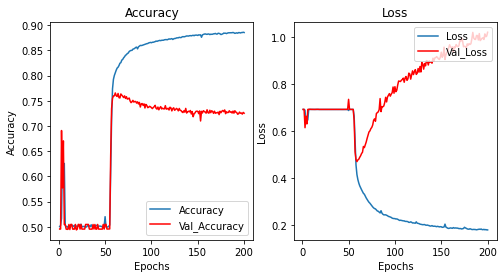

1532/1532 - 4s - loss: 0.4741 - accuracy: 0.7568
[0.47412317991256714, 0.7568422555923462]


In [44]:
sb_tokenizer = SpaceBasedTokenizer(corpus)
X_train, y_train, X_test, y_test, word_index, index_word = load_data(sb_tokenizer)
X_train, X_val, y_train, y_val = train_test_split(X_train, y_train, test_size=0.2, random_state=random_state)

ckpt_path = "checkpoint.ckpt"
checkpoint = create_checkpoint_callback(ckpt_path, verbos=1)

model = create_lstm_model(vocab_size, word_vector_dim)
model.summary()
model.compile(optimizer='adam',
             loss='binary_crossentropy',
             metrics=['accuracy'])

history = model.fit(X_train,
                   y_train,
                   epochs=epochs,
                   batch_size=batch_size,
                   validation_data=(X_val, y_val),
                   verbose=1,
                   callbacks=[checkpoint])

draw_history(history)

model.load_weights(ckpt_path)
results = model.evaluate(X_test,  y_test, verbose=2)
print(results)

### 형태소 기반 Tokenizer

data loading from file..
original train_data:150000, test_data:50000
cleaned train_data:145860, test_data:48997

Success!
Train data sample : [1] 신카이 마코토의 작화와,미유와 하나카나가 연기를 잘해줘서 더대박이였다.
Test data sample : [0] 걸작은 몇안되고 졸작들만 넘쳐난다.

encoding..
Train data sample : [1]
	[13898, 12047, 9, 2853, 71, 18, 43909, 71, 131, 2179, 27, 10, 60, 22, 63, 76, 1482, 83, 309, 2, 112, 5, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0]
	신카이 마코토 의 작화 와 , 미유 와 하나 카 나 가 연기 를 잘 해 줘서 더 대박 이 였 다 . <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PA

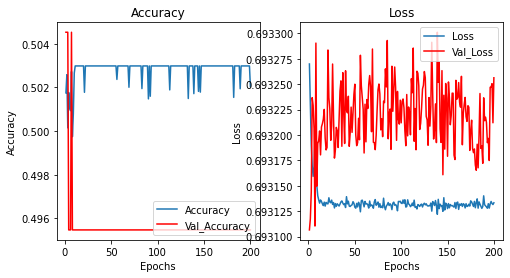

1532/1532 - 5s - loss: 0.6931 - accuracy: 0.5030
[0.6931332945823669, 0.5029900074005127]


In [45]:
morphs_tokenizer = MorphsTokenizer(corpus)
X_train, y_train, X_test, y_test, word_index, index_word = load_data(morphs_tokenizer)
X_train, X_val, y_train, y_val = train_test_split(X_train, y_train, test_size=0.2, random_state=random_state)

ckpt_path = "checkpoint.ckpt"
checkpoint = create_checkpoint_callback(ckpt_path, verbos=1)

model = create_lstm_model(vocab_size, word_vector_dim)
model.summary()
model.compile(optimizer='adam',
             loss='binary_crossentropy',
             metrics=['accuracy'])

history = model.fit(X_train,
                   y_train,
                   epochs=epochs,
                   batch_size=batch_size,
                   validation_data=(X_val, y_val),
                   verbose=1,
                   callbacks=[checkpoint])

draw_history(history)

model.load_weights(ckpt_path)
results = model.evaluate(X_test,  y_test, verbose=2)
print(results)

### Sentence Piece 기반 Tokenizer (unigram)

data loading from file..
original train_data:150000, test_data:50000
cleaned train_data:145860, test_data:48997

Success!
Train data sample : [1] 신카이 마코토의 작화와,미유와 하나카나가 연기를 잘해줘서 더대박이였다.
Test data sample : [0] 걸작은 몇안되고 졸작들만 넘쳐난다.

encoding..
Train data sample : [1]
	[410, 489, 6, 350, 668, 577, 9, 6606, 50, 13, 124, 294, 50, 219, 489, 30, 10, 1017, 43, 6658, 54, 1577, 3651, 3, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0]
	신카이 마코토의 작화와,미유와 하나카나가 연기를 잘해줘서 더대박이였다. ⁇  ⁇  ⁇  ⁇  ⁇  ⁇  ⁇  ⁇  ⁇  ⁇  ⁇  ⁇  ⁇  ⁇  ⁇  ⁇  ⁇  ⁇  ⁇  ⁇  ⁇  ⁇  ⁇  ⁇  ⁇  ⁇  ⁇  ⁇  ⁇  ⁇  ⁇  ⁇  ⁇  ⁇  ⁇  ⁇  ⁇  ⁇  ⁇  ⁇  ⁇  ⁇  ⁇  ⁇  ⁇  ⁇  ⁇  ⁇  ⁇  ⁇  ⁇  ⁇  ⁇  ⁇  ⁇  ⁇  ⁇  ⁇  ⁇  ⁇  ⁇  ⁇  ⁇  ⁇  ⁇  ⁇  ⁇  ⁇  ⁇  ⁇  ⁇  ⁇  ⁇  ⁇  ⁇  ⁇ 
Test data sample : [0]
	[1032, 17, 617, 6516, 743, 3219, 7499, 911, 3, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,

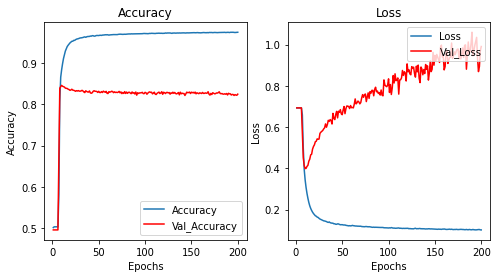

1532/1532 - 4s - loss: 0.4027 - accuracy: 0.8434
[0.4026583731174469, 0.8433577418327332]


In [46]:
sp_unigram_tokenizer = SentencePieceTokenizer(corpus, "unigram", vocab_size)
X_train, y_train, X_test, y_test, word_index, index_word = load_data(sp_unigram_tokenizer)
X_train, X_val, y_train, y_val = train_test_split(X_train, y_train, test_size=0.2, random_state=random_state)

ckpt_path = "checkpoint.ckpt"
checkpoint = create_checkpoint_callback(ckpt_path, verbos=1)


model = create_lstm_model(vocab_size, word_vector_dim)
model.summary()
model.compile(optimizer='adam',
             loss='binary_crossentropy',
             metrics=['accuracy'])

history = model.fit(X_train,
                   y_train,
                   epochs=epochs,
                   batch_size=batch_size,
                   validation_data=(X_val, y_val),
                   verbose=1,
                   callbacks=[checkpoint])

draw_history(history)

model.load_weights(ckpt_path)
results = model.evaluate(X_test,  y_test, verbose=2)
print(results)

### Sentence Piece 기반 Tokenizer (unigram)

data loading from file..
original train_data:150000, test_data:50000
cleaned train_data:145860, test_data:48997

Success!
Train data sample : [1] 신카이 마코토의 작화와,미유와 하나카나가 연기를 잘해줘서 더대박이였다.
Test data sample : [0] 걸작은 몇안되고 졸작들만 넘쳐난다.

encoding..
Train data sample : [1]
	[177, 8642, 8301, 56, 8514, 8434, 8317, 6998, 8410, 8339, 8341, 8427, 8410, 211, 8642, 2713, 1235, 63, 8348, 2907, 67, 1821, 4414, 8300, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0]
	신카이 마코토의 작화와,미유와 하나카나가 연기를 잘해줘서 더대박이였다. ⁇  ⁇  ⁇  ⁇  ⁇  ⁇  ⁇  ⁇  ⁇  ⁇  ⁇  ⁇  ⁇  ⁇  ⁇  ⁇  ⁇  ⁇  ⁇  ⁇  ⁇  ⁇  ⁇  ⁇  ⁇  ⁇  ⁇  ⁇  ⁇  ⁇  ⁇  ⁇  ⁇  ⁇  ⁇  ⁇  ⁇  ⁇  ⁇  ⁇  ⁇  ⁇  ⁇  ⁇  ⁇  ⁇  ⁇  ⁇  ⁇  ⁇  ⁇  ⁇  ⁇  ⁇  ⁇  ⁇  ⁇  ⁇  ⁇  ⁇  ⁇  ⁇  ⁇  ⁇  ⁇  ⁇  ⁇  ⁇  ⁇  ⁇  ⁇  ⁇  ⁇  ⁇  ⁇  ⁇ 
Test data sample : [0]
	[1176, 8320, 455, 7994, 989, 1704, 7522, 730, 8300, 0, 0, 0, 0, 0, 0, 0, 0, 

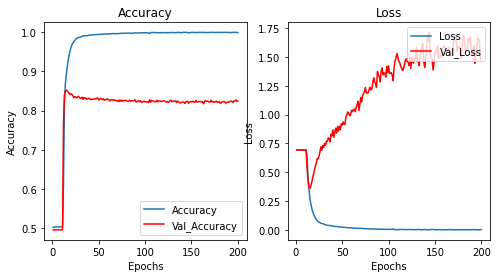

1532/1532 - 4s - loss: 0.3661 - accuracy: 0.8482
[0.3661491572856903, 0.8481539487838745]


In [47]:
sp_bpe_tokenizer = SentencePieceTokenizer(corpus, "bpe", vocab_size)
X_train, y_train, X_test, y_test, word_index, index_word = load_data(sp_bpe_tokenizer)
X_train, X_val, y_train, y_val = train_test_split(X_train, y_train, test_size=0.2, random_state=random_state)

ckpt_path = "checkpoint.ckpt"
checkpoint = create_checkpoint_callback(ckpt_path, verbos=1)


model = create_lstm_model(vocab_size, word_vector_dim)
model.summary()
model.compile(optimizer='adam',
             loss='binary_crossentropy',
             metrics=['accuracy'])

history = model.fit(X_train,
                   y_train,
                   epochs=epochs,
                   batch_size=batch_size,
                   validation_data=(X_val, y_val),
                   verbose=1,
                   callbacks=[checkpoint])

draw_history(history)

model.load_weights(ckpt_path)
results = model.evaluate(X_test,  y_test, verbose=2)
print(results)

## 파라미터 조정

### vocab_size 3000

In [48]:
vocab_size=3000
epochs=200

In [49]:
tokenizers = [SpaceBasedTokenizer(corpus),
              MorphsTokenizer(corpus),
              SentencePieceTokenizer(corpus, "unigram", vocab_size),
              SentencePieceTokenizer(corpus, "bpe", vocab_size)]

data loading from file..
original train_data:150000, test_data:50000
cleaned train_data:145860, test_data:48997

Success!
Train data sample : [1] 신카이 마코토의 작화와,미유와 하나카나가 연기를 잘해줘서 더대박이였다.
Test data sample : [0] 걸작은 몇안되고 졸작들만 넘쳐난다.

encoding..
Train data sample : [1]
	[177, 8642, 8301, 56, 8514, 8434, 8317, 6998, 8410, 8339, 8341, 8427, 8410, 211, 8642, 2713, 1235, 63, 8348, 2907, 67, 1821, 4414, 8300, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0]
	신카이 마코토의 작화와,미유와 하나카나가 연기를 잘해줘서 더대박이였다. ⁇  ⁇  ⁇  ⁇  ⁇  ⁇  ⁇  ⁇  ⁇  ⁇  ⁇  ⁇  ⁇  ⁇  ⁇  ⁇  ⁇  ⁇  ⁇  ⁇  ⁇  ⁇  ⁇  ⁇  ⁇  ⁇  ⁇  ⁇  ⁇  ⁇  ⁇  ⁇  ⁇  ⁇  ⁇  ⁇  ⁇  ⁇  ⁇  ⁇  ⁇  ⁇  ⁇  ⁇  ⁇  ⁇  ⁇  ⁇  ⁇  ⁇  ⁇  ⁇  ⁇  ⁇  ⁇  ⁇  ⁇  ⁇  ⁇  ⁇  ⁇  ⁇  ⁇  ⁇  ⁇  ⁇  ⁇  ⁇  ⁇  ⁇  ⁇  ⁇  ⁇  ⁇  ⁇  ⁇ 
Test data sample : [0]
	[1176, 8320, 455, 7994, 989, 1704, 7522, 730, 8300, 0, 0, 0, 0, 0, 0, 0, 0, 

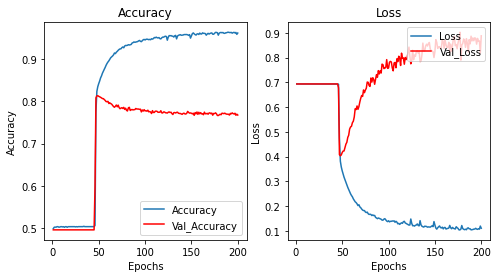

1532/1532 - 4s - loss: 0.4071 - accuracy: 0.8100
data loading from file..
original train_data:150000, test_data:50000
cleaned train_data:145860, test_data:48997

Success!
Train data sample : [1] 신카이 마코토의 작화와,미유와 하나카나가 연기를 잘해줘서 더대박이였다.
Test data sample : [0] 걸작은 몇안되고 졸작들만 넘쳐난다.

encoding..
Train data sample : [1]
	[177, 8642, 8301, 56, 8514, 8434, 8317, 6998, 8410, 8339, 8341, 8427, 8410, 211, 8642, 2713, 1235, 63, 8348, 2907, 67, 1821, 4414, 8300, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0]
	신카이 마코토의 작화와,미유와 하나카나가 연기를 잘해줘서 더대박이였다. ⁇  ⁇  ⁇  ⁇  ⁇  ⁇  ⁇  ⁇  ⁇  ⁇  ⁇  ⁇  ⁇  ⁇  ⁇  ⁇  ⁇  ⁇  ⁇  ⁇  ⁇  ⁇  ⁇  ⁇  ⁇  ⁇  ⁇  ⁇  ⁇  ⁇  ⁇  ⁇  ⁇  ⁇  ⁇  ⁇  ⁇  ⁇  ⁇  ⁇  ⁇  ⁇  ⁇  ⁇  ⁇  ⁇  ⁇  ⁇  ⁇  ⁇  ⁇  ⁇  ⁇  ⁇  ⁇  ⁇  ⁇  ⁇  ⁇  ⁇  ⁇  ⁇  ⁇  ⁇  ⁇  ⁇  ⁇  ⁇  ⁇  ⁇  ⁇  ⁇  ⁇  ⁇  ⁇  ⁇ 
Test data sample : [0]
	[1176, 8320, 455, 7994, 989

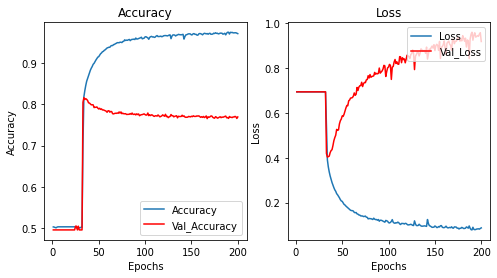

1532/1532 - 4s - loss: 0.4039 - accuracy: 0.8095
data loading from file..
original train_data:150000, test_data:50000
cleaned train_data:145860, test_data:48997

Success!
Train data sample : [1] 신카이 마코토의 작화와,미유와 하나카나가 연기를 잘해줘서 더대박이였다.
Test data sample : [0] 걸작은 몇안되고 졸작들만 넘쳐난다.

encoding..
Train data sample : [1]
	[177, 8642, 8301, 56, 8514, 8434, 8317, 6998, 8410, 8339, 8341, 8427, 8410, 211, 8642, 2713, 1235, 63, 8348, 2907, 67, 1821, 4414, 8300, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0]
	신카이 마코토의 작화와,미유와 하나카나가 연기를 잘해줘서 더대박이였다. ⁇  ⁇  ⁇  ⁇  ⁇  ⁇  ⁇  ⁇  ⁇  ⁇  ⁇  ⁇  ⁇  ⁇  ⁇  ⁇  ⁇  ⁇  ⁇  ⁇  ⁇  ⁇  ⁇  ⁇  ⁇  ⁇  ⁇  ⁇  ⁇  ⁇  ⁇  ⁇  ⁇  ⁇  ⁇  ⁇  ⁇  ⁇  ⁇  ⁇  ⁇  ⁇  ⁇  ⁇  ⁇  ⁇  ⁇  ⁇  ⁇  ⁇  ⁇  ⁇  ⁇  ⁇  ⁇  ⁇  ⁇  ⁇  ⁇  ⁇  ⁇  ⁇  ⁇  ⁇  ⁇  ⁇  ⁇  ⁇  ⁇  ⁇  ⁇  ⁇  ⁇  ⁇  ⁇  ⁇ 
Test data sample : [0]
	[1176, 8320, 455, 7994, 989

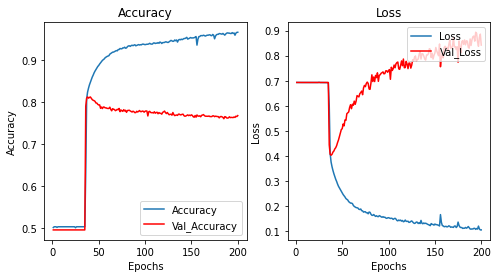

1532/1532 - 4s - loss: 0.4049 - accuracy: 0.8100
data loading from file..
original train_data:150000, test_data:50000
cleaned train_data:145860, test_data:48997

Success!
Train data sample : [1] 신카이 마코토의 작화와,미유와 하나카나가 연기를 잘해줘서 더대박이였다.
Test data sample : [0] 걸작은 몇안되고 졸작들만 넘쳐난다.

encoding..
Train data sample : [1]
	[177, 8642, 8301, 56, 8514, 8434, 8317, 6998, 8410, 8339, 8341, 8427, 8410, 211, 8642, 2713, 1235, 63, 8348, 2907, 67, 1821, 4414, 8300, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0]
	신카이 마코토의 작화와,미유와 하나카나가 연기를 잘해줘서 더대박이였다. ⁇  ⁇  ⁇  ⁇  ⁇  ⁇  ⁇  ⁇  ⁇  ⁇  ⁇  ⁇  ⁇  ⁇  ⁇  ⁇  ⁇  ⁇  ⁇  ⁇  ⁇  ⁇  ⁇  ⁇  ⁇  ⁇  ⁇  ⁇  ⁇  ⁇  ⁇  ⁇  ⁇  ⁇  ⁇  ⁇  ⁇  ⁇  ⁇  ⁇  ⁇  ⁇  ⁇  ⁇  ⁇  ⁇  ⁇  ⁇  ⁇  ⁇  ⁇  ⁇  ⁇  ⁇  ⁇  ⁇  ⁇  ⁇  ⁇  ⁇  ⁇  ⁇  ⁇  ⁇  ⁇  ⁇  ⁇  ⁇  ⁇  ⁇  ⁇  ⁇  ⁇  ⁇  ⁇  ⁇ 
Test data sample : [0]
	[1176, 8320, 455, 7994, 989

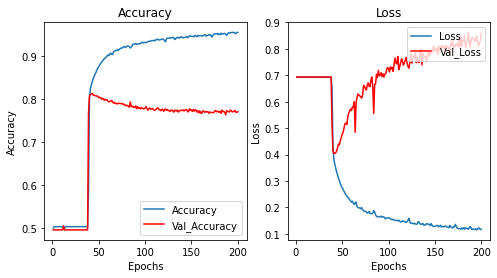

1532/1532 - 4s - loss: 0.4069 - accuracy: 0.8088


In [50]:
result_dict = {}
for tokenizer in tokenizers:
  X_train, y_train, X_test, y_test, word_index, index_word = load_data(sp_bpe_tokenizer)
  X_train, X_val, y_train, y_val = train_test_split(X_train, y_train, test_size=0.2, random_state=random_state)

  ckpt_path = "checkpoint.ckpt"
  checkpoint = create_checkpoint_callback(ckpt_path, verbos=0)

  model = create_lstm_model(vocab_size, word_vector_dim)
  model.compile(optimizer='adam',
              loss='binary_crossentropy',
              metrics=['accuracy'])

  history = model.fit(X_train,
                    y_train,
                    epochs=epochs,
                    batch_size=batch_size,
                    validation_data=(X_val, y_val),
                    verbose=0,
                    callbacks=[checkpoint])

  draw_history(history)

  model.load_weights(ckpt_path)
  results = model.evaluate(X_test,  y_test, verbose=2)

  result_dict[tokenizer.to_string()] = results

In [51]:
for key, value in result_dict.items():
  print(key, value)

SpaceBasedTokenizer [0.40710699558258057, 0.8099679350852966]
MorphsTokenizer [0.40389877557754517, 0.8095189332962036]
SentencePieceTokenizer-unigram [0.40493860840797424, 0.8099883794784546]
SentencePieceTokenizer-bpe [0.40687260031700134, 0.8088250160217285]


### vocab_size 5000

In [52]:
vocab_size=5000
epochs=200

In [53]:
tokenizers = [SpaceBasedTokenizer(corpus),
              MorphsTokenizer(corpus),
              SentencePieceTokenizer(corpus, "unigram", vocab_size),
              SentencePieceTokenizer(corpus, "bpe", vocab_size)]

data loading from file..
original train_data:150000, test_data:50000
cleaned train_data:145860, test_data:48997

Success!
Train data sample : [1] 신카이 마코토의 작화와,미유와 하나카나가 연기를 잘해줘서 더대박이였다.
Test data sample : [0] 걸작은 몇안되고 졸작들만 넘쳐난다.

encoding..
Train data sample : [1]
	[177, 8642, 8301, 56, 8514, 8434, 8317, 6998, 8410, 8339, 8341, 8427, 8410, 211, 8642, 2713, 1235, 63, 8348, 2907, 67, 1821, 4414, 8300, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0]
	신카이 마코토의 작화와,미유와 하나카나가 연기를 잘해줘서 더대박이였다. ⁇  ⁇  ⁇  ⁇  ⁇  ⁇  ⁇  ⁇  ⁇  ⁇  ⁇  ⁇  ⁇  ⁇  ⁇  ⁇  ⁇  ⁇  ⁇  ⁇  ⁇  ⁇  ⁇  ⁇  ⁇  ⁇  ⁇  ⁇  ⁇  ⁇  ⁇  ⁇  ⁇  ⁇  ⁇  ⁇  ⁇  ⁇  ⁇  ⁇  ⁇  ⁇  ⁇  ⁇  ⁇  ⁇  ⁇  ⁇  ⁇  ⁇  ⁇  ⁇  ⁇  ⁇  ⁇  ⁇  ⁇  ⁇  ⁇  ⁇  ⁇  ⁇  ⁇  ⁇  ⁇  ⁇  ⁇  ⁇  ⁇  ⁇  ⁇  ⁇  ⁇  ⁇  ⁇  ⁇ 
Test data sample : [0]
	[1176, 8320, 455, 7994, 989, 1704, 7522, 730, 8300, 0, 0, 0, 0, 0, 0, 0, 0, 

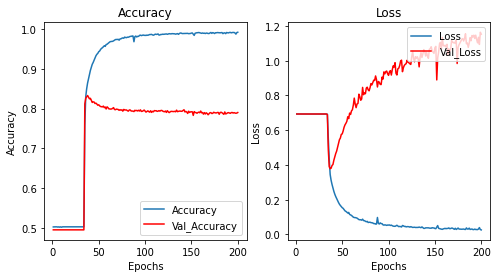

1532/1532 - 4s - loss: 0.3808 - accuracy: 0.8266
data loading from file..
original train_data:150000, test_data:50000
cleaned train_data:145860, test_data:48997

Success!
Train data sample : [1] 신카이 마코토의 작화와,미유와 하나카나가 연기를 잘해줘서 더대박이였다.
Test data sample : [0] 걸작은 몇안되고 졸작들만 넘쳐난다.

encoding..
Train data sample : [1]
	[177, 8642, 8301, 56, 8514, 8434, 8317, 6998, 8410, 8339, 8341, 8427, 8410, 211, 8642, 2713, 1235, 63, 8348, 2907, 67, 1821, 4414, 8300, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0]
	신카이 마코토의 작화와,미유와 하나카나가 연기를 잘해줘서 더대박이였다. ⁇  ⁇  ⁇  ⁇  ⁇  ⁇  ⁇  ⁇  ⁇  ⁇  ⁇  ⁇  ⁇  ⁇  ⁇  ⁇  ⁇  ⁇  ⁇  ⁇  ⁇  ⁇  ⁇  ⁇  ⁇  ⁇  ⁇  ⁇  ⁇  ⁇  ⁇  ⁇  ⁇  ⁇  ⁇  ⁇  ⁇  ⁇  ⁇  ⁇  ⁇  ⁇  ⁇  ⁇  ⁇  ⁇  ⁇  ⁇  ⁇  ⁇  ⁇  ⁇  ⁇  ⁇  ⁇  ⁇  ⁇  ⁇  ⁇  ⁇  ⁇  ⁇  ⁇  ⁇  ⁇  ⁇  ⁇  ⁇  ⁇  ⁇  ⁇  ⁇  ⁇  ⁇  ⁇  ⁇ 
Test data sample : [0]
	[1176, 8320, 455, 7994, 989

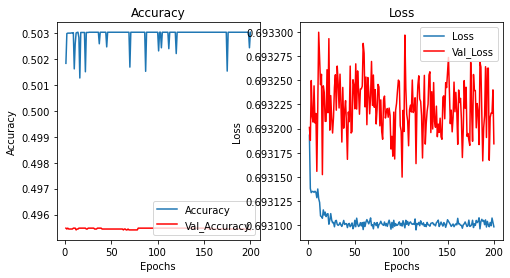

1532/1532 - 4s - loss: 0.6931 - accuracy: 0.4971
data loading from file..
original train_data:150000, test_data:50000
cleaned train_data:145860, test_data:48997

Success!
Train data sample : [1] 신카이 마코토의 작화와,미유와 하나카나가 연기를 잘해줘서 더대박이였다.
Test data sample : [0] 걸작은 몇안되고 졸작들만 넘쳐난다.

encoding..
Train data sample : [1]
	[177, 8642, 8301, 56, 8514, 8434, 8317, 6998, 8410, 8339, 8341, 8427, 8410, 211, 8642, 2713, 1235, 63, 8348, 2907, 67, 1821, 4414, 8300, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0]
	신카이 마코토의 작화와,미유와 하나카나가 연기를 잘해줘서 더대박이였다. ⁇  ⁇  ⁇  ⁇  ⁇  ⁇  ⁇  ⁇  ⁇  ⁇  ⁇  ⁇  ⁇  ⁇  ⁇  ⁇  ⁇  ⁇  ⁇  ⁇  ⁇  ⁇  ⁇  ⁇  ⁇  ⁇  ⁇  ⁇  ⁇  ⁇  ⁇  ⁇  ⁇  ⁇  ⁇  ⁇  ⁇  ⁇  ⁇  ⁇  ⁇  ⁇  ⁇  ⁇  ⁇  ⁇  ⁇  ⁇  ⁇  ⁇  ⁇  ⁇  ⁇  ⁇  ⁇  ⁇  ⁇  ⁇  ⁇  ⁇  ⁇  ⁇  ⁇  ⁇  ⁇  ⁇  ⁇  ⁇  ⁇  ⁇  ⁇  ⁇  ⁇  ⁇  ⁇  ⁇ 
Test data sample : [0]
	[1176, 8320, 455, 7994, 989

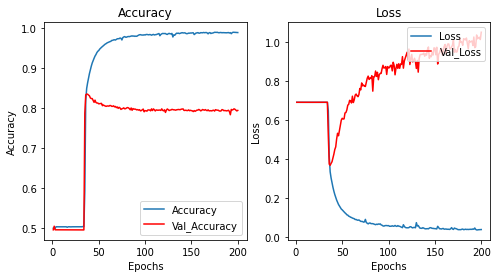

1532/1532 - 4s - loss: 0.3739 - accuracy: 0.8301
data loading from file..
original train_data:150000, test_data:50000
cleaned train_data:145860, test_data:48997

Success!
Train data sample : [1] 신카이 마코토의 작화와,미유와 하나카나가 연기를 잘해줘서 더대박이였다.
Test data sample : [0] 걸작은 몇안되고 졸작들만 넘쳐난다.

encoding..
Train data sample : [1]
	[177, 8642, 8301, 56, 8514, 8434, 8317, 6998, 8410, 8339, 8341, 8427, 8410, 211, 8642, 2713, 1235, 63, 8348, 2907, 67, 1821, 4414, 8300, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0]
	신카이 마코토의 작화와,미유와 하나카나가 연기를 잘해줘서 더대박이였다. ⁇  ⁇  ⁇  ⁇  ⁇  ⁇  ⁇  ⁇  ⁇  ⁇  ⁇  ⁇  ⁇  ⁇  ⁇  ⁇  ⁇  ⁇  ⁇  ⁇  ⁇  ⁇  ⁇  ⁇  ⁇  ⁇  ⁇  ⁇  ⁇  ⁇  ⁇  ⁇  ⁇  ⁇  ⁇  ⁇  ⁇  ⁇  ⁇  ⁇  ⁇  ⁇  ⁇  ⁇  ⁇  ⁇  ⁇  ⁇  ⁇  ⁇  ⁇  ⁇  ⁇  ⁇  ⁇  ⁇  ⁇  ⁇  ⁇  ⁇  ⁇  ⁇  ⁇  ⁇  ⁇  ⁇  ⁇  ⁇  ⁇  ⁇  ⁇  ⁇  ⁇  ⁇  ⁇  ⁇ 
Test data sample : [0]
	[1176, 8320, 455, 7994, 989

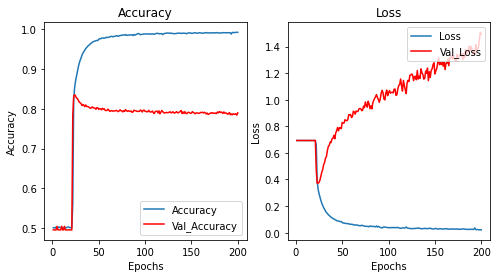

1532/1532 - 4s - loss: 0.3741 - accuracy: 0.8293


In [54]:
result_dict = {}
for tokenizer in tokenizers:
  X_train, y_train, X_test, y_test, word_index, index_word = load_data(sp_bpe_tokenizer)
  X_train, X_val, y_train, y_val = train_test_split(X_train, y_train, test_size=0.2, random_state=random_state)

  ckpt_path = "checkpoint.ckpt"
  checkpoint = create_checkpoint_callback(ckpt_path, verbos=0)

  model = create_lstm_model(vocab_size, word_vector_dim)
  model.compile(optimizer='adam',
              loss='binary_crossentropy',
              metrics=['accuracy'])

  history = model.fit(X_train,
                    y_train,
                    epochs=epochs,
                    batch_size=batch_size,
                    validation_data=(X_val, y_val),
                    verbose=0,
                    callbacks=[checkpoint])

  draw_history(history)

  model.load_weights(ckpt_path)
  results = model.evaluate(X_test,  y_test, verbose=2)

  result_dict[tokenizer.to_string()] = results

In [55]:
for key, value in result_dict.items():
  print(key, value)

SpaceBasedTokenizer [0.3808203935623169, 0.8266016244888306]
MorphsTokenizer [0.6931325793266296, 0.497071236371994]
SentencePieceTokenizer-unigram [0.3738535940647125, 0.8301324844360352]
SentencePieceTokenizer-bpe [0.37406447529792786, 0.8293160796165466]


### vocab_size 20000

In [56]:
vocab_size=20000
epochs=300

In [57]:
tokenizers = [SpaceBasedTokenizer(corpus),
              MorphsTokenizer(corpus),
              SentencePieceTokenizer(corpus, "unigram", vocab_size),
              SentencePieceTokenizer(corpus, "bpe", vocab_size)]

data loading from file..
original train_data:150000, test_data:50000
cleaned train_data:145860, test_data:48997

Success!
Train data sample : [1] 신카이 마코토의 작화와,미유와 하나카나가 연기를 잘해줘서 더대박이였다.
Test data sample : [0] 걸작은 몇안되고 졸작들만 넘쳐난다.

encoding..
Train data sample : [1]
	[177, 8642, 8301, 56, 8514, 8434, 8317, 6998, 8410, 8339, 8341, 8427, 8410, 211, 8642, 2713, 1235, 63, 8348, 2907, 67, 1821, 4414, 8300, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0]
	신카이 마코토의 작화와,미유와 하나카나가 연기를 잘해줘서 더대박이였다. ⁇  ⁇  ⁇  ⁇  ⁇  ⁇  ⁇  ⁇  ⁇  ⁇  ⁇  ⁇  ⁇  ⁇  ⁇  ⁇  ⁇  ⁇  ⁇  ⁇  ⁇  ⁇  ⁇  ⁇  ⁇  ⁇  ⁇  ⁇  ⁇  ⁇  ⁇  ⁇  ⁇  ⁇  ⁇  ⁇  ⁇  ⁇  ⁇  ⁇  ⁇  ⁇  ⁇  ⁇  ⁇  ⁇  ⁇  ⁇  ⁇  ⁇  ⁇  ⁇  ⁇  ⁇  ⁇  ⁇  ⁇  ⁇  ⁇  ⁇  ⁇  ⁇  ⁇  ⁇  ⁇  ⁇  ⁇  ⁇  ⁇  ⁇  ⁇  ⁇  ⁇  ⁇  ⁇  ⁇ 
Test data sample : [0]
	[1176, 8320, 455, 7994, 989, 1704, 7522, 730, 8300, 0, 0, 0, 0, 0, 0, 0, 0, 

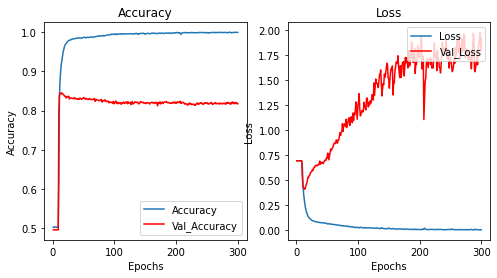

1532/1532 - 4s - loss: 0.4154 - accuracy: 0.8383
data loading from file..
original train_data:150000, test_data:50000
cleaned train_data:145860, test_data:48997

Success!
Train data sample : [1] 신카이 마코토의 작화와,미유와 하나카나가 연기를 잘해줘서 더대박이였다.
Test data sample : [0] 걸작은 몇안되고 졸작들만 넘쳐난다.

encoding..
Train data sample : [1]
	[177, 8642, 8301, 56, 8514, 8434, 8317, 6998, 8410, 8339, 8341, 8427, 8410, 211, 8642, 2713, 1235, 63, 8348, 2907, 67, 1821, 4414, 8300, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0]
	신카이 마코토의 작화와,미유와 하나카나가 연기를 잘해줘서 더대박이였다. ⁇  ⁇  ⁇  ⁇  ⁇  ⁇  ⁇  ⁇  ⁇  ⁇  ⁇  ⁇  ⁇  ⁇  ⁇  ⁇  ⁇  ⁇  ⁇  ⁇  ⁇  ⁇  ⁇  ⁇  ⁇  ⁇  ⁇  ⁇  ⁇  ⁇  ⁇  ⁇  ⁇  ⁇  ⁇  ⁇  ⁇  ⁇  ⁇  ⁇  ⁇  ⁇  ⁇  ⁇  ⁇  ⁇  ⁇  ⁇  ⁇  ⁇  ⁇  ⁇  ⁇  ⁇  ⁇  ⁇  ⁇  ⁇  ⁇  ⁇  ⁇  ⁇  ⁇  ⁇  ⁇  ⁇  ⁇  ⁇  ⁇  ⁇  ⁇  ⁇  ⁇  ⁇  ⁇  ⁇ 
Test data sample : [0]
	[1176, 8320, 455, 7994, 989

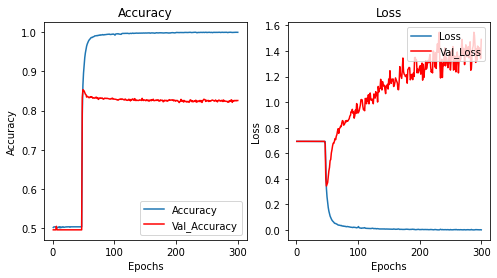

1532/1532 - 4s - loss: 0.3518 - accuracy: 0.8486
data loading from file..
original train_data:150000, test_data:50000
cleaned train_data:145860, test_data:48997

Success!
Train data sample : [1] 신카이 마코토의 작화와,미유와 하나카나가 연기를 잘해줘서 더대박이였다.
Test data sample : [0] 걸작은 몇안되고 졸작들만 넘쳐난다.

encoding..
Train data sample : [1]
	[177, 8642, 8301, 56, 8514, 8434, 8317, 6998, 8410, 8339, 8341, 8427, 8410, 211, 8642, 2713, 1235, 63, 8348, 2907, 67, 1821, 4414, 8300, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0]
	신카이 마코토의 작화와,미유와 하나카나가 연기를 잘해줘서 더대박이였다. ⁇  ⁇  ⁇  ⁇  ⁇  ⁇  ⁇  ⁇  ⁇  ⁇  ⁇  ⁇  ⁇  ⁇  ⁇  ⁇  ⁇  ⁇  ⁇  ⁇  ⁇  ⁇  ⁇  ⁇  ⁇  ⁇  ⁇  ⁇  ⁇  ⁇  ⁇  ⁇  ⁇  ⁇  ⁇  ⁇  ⁇  ⁇  ⁇  ⁇  ⁇  ⁇  ⁇  ⁇  ⁇  ⁇  ⁇  ⁇  ⁇  ⁇  ⁇  ⁇  ⁇  ⁇  ⁇  ⁇  ⁇  ⁇  ⁇  ⁇  ⁇  ⁇  ⁇  ⁇  ⁇  ⁇  ⁇  ⁇  ⁇  ⁇  ⁇  ⁇  ⁇  ⁇  ⁇  ⁇ 
Test data sample : [0]
	[1176, 8320, 455, 7994, 989

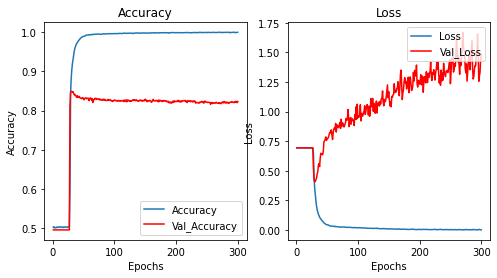

1532/1532 - 4s - loss: 0.4079 - accuracy: 0.8459
data loading from file..
original train_data:150000, test_data:50000
cleaned train_data:145860, test_data:48997

Success!
Train data sample : [1] 신카이 마코토의 작화와,미유와 하나카나가 연기를 잘해줘서 더대박이였다.
Test data sample : [0] 걸작은 몇안되고 졸작들만 넘쳐난다.

encoding..
Train data sample : [1]
	[177, 8642, 8301, 56, 8514, 8434, 8317, 6998, 8410, 8339, 8341, 8427, 8410, 211, 8642, 2713, 1235, 63, 8348, 2907, 67, 1821, 4414, 8300, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0]
	신카이 마코토의 작화와,미유와 하나카나가 연기를 잘해줘서 더대박이였다. ⁇  ⁇  ⁇  ⁇  ⁇  ⁇  ⁇  ⁇  ⁇  ⁇  ⁇  ⁇  ⁇  ⁇  ⁇  ⁇  ⁇  ⁇  ⁇  ⁇  ⁇  ⁇  ⁇  ⁇  ⁇  ⁇  ⁇  ⁇  ⁇  ⁇  ⁇  ⁇  ⁇  ⁇  ⁇  ⁇  ⁇  ⁇  ⁇  ⁇  ⁇  ⁇  ⁇  ⁇  ⁇  ⁇  ⁇  ⁇  ⁇  ⁇  ⁇  ⁇  ⁇  ⁇  ⁇  ⁇  ⁇  ⁇  ⁇  ⁇  ⁇  ⁇  ⁇  ⁇  ⁇  ⁇  ⁇  ⁇  ⁇  ⁇  ⁇  ⁇  ⁇  ⁇  ⁇  ⁇ 
Test data sample : [0]
	[1176, 8320, 455, 7994, 989

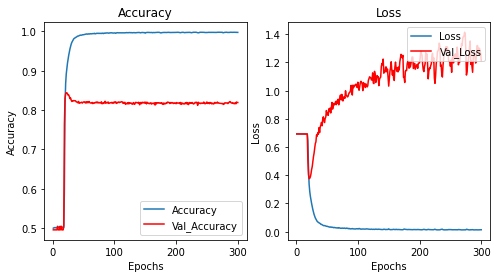

1532/1532 - 4s - loss: 0.3839 - accuracy: 0.8377


In [58]:
result_dict = {}
for tokenizer in tokenizers:
  X_train, y_train, X_test, y_test, word_index, index_word = load_data(sp_bpe_tokenizer)
  X_train, X_val, y_train, y_val = train_test_split(X_train, y_train, test_size=0.2, random_state=random_state)

  ckpt_path = "checkpoint.ckpt"
  checkpoint = create_checkpoint_callback(ckpt_path, verbos=0)

  model = create_lstm_model(vocab_size, word_vector_dim)
  model.compile(optimizer='adam',
              loss='binary_crossentropy',
              metrics=['accuracy'])

  history = model.fit(X_train,
                    y_train,
                    epochs=epochs,
                    batch_size=batch_size,
                    validation_data=(X_val, y_val),
                    verbose=0,
                    callbacks=[checkpoint])

  draw_history(history)

  model.load_weights(ckpt_path)
  results = model.evaluate(X_test,  y_test, verbose=2)

  result_dict[tokenizer.to_string()] = results

In [59]:
for key, value in result_dict.items():
  print(key, value)

SpaceBasedTokenizer [0.4154239594936371, 0.8383370637893677]
MorphsTokenizer [0.3518323004245758, 0.8486437797546387]
SentencePieceTokenizer-unigram [0.4079021215438843, 0.8459089398384094]
SentencePieceTokenizer-bpe [0.38392147421836853, 0.8376635313034058]


### vocab_size 30000

In [60]:
vocab_size=30000
epochs=300

In [61]:
tokenizers = [SpaceBasedTokenizer(corpus),
              MorphsTokenizer(corpus),
              SentencePieceTokenizer(corpus, "unigram", vocab_size),
              SentencePieceTokenizer(corpus, "bpe", vocab_size)]

data loading from file..
original train_data:150000, test_data:50000
cleaned train_data:145860, test_data:48997

Success!
Train data sample : [1] 신카이 마코토의 작화와,미유와 하나카나가 연기를 잘해줘서 더대박이였다.
Test data sample : [0] 걸작은 몇안되고 졸작들만 넘쳐난다.

encoding..
Train data sample : [1]
	[177, 8642, 8301, 56, 8514, 8434, 8317, 6998, 8410, 8339, 8341, 8427, 8410, 211, 8642, 2713, 1235, 63, 8348, 2907, 67, 1821, 4414, 8300, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0]
	신카이 마코토의 작화와,미유와 하나카나가 연기를 잘해줘서 더대박이였다. ⁇  ⁇  ⁇  ⁇  ⁇  ⁇  ⁇  ⁇  ⁇  ⁇  ⁇  ⁇  ⁇  ⁇  ⁇  ⁇  ⁇  ⁇  ⁇  ⁇  ⁇  ⁇  ⁇  ⁇  ⁇  ⁇  ⁇  ⁇  ⁇  ⁇  ⁇  ⁇  ⁇  ⁇  ⁇  ⁇  ⁇  ⁇  ⁇  ⁇  ⁇  ⁇  ⁇  ⁇  ⁇  ⁇  ⁇  ⁇  ⁇  ⁇  ⁇  ⁇  ⁇  ⁇  ⁇  ⁇  ⁇  ⁇  ⁇  ⁇  ⁇  ⁇  ⁇  ⁇  ⁇  ⁇  ⁇  ⁇  ⁇  ⁇  ⁇  ⁇  ⁇  ⁇  ⁇  ⁇ 
Test data sample : [0]
	[1176, 8320, 455, 7994, 989, 1704, 7522, 730, 8300, 0, 0, 0, 0, 0, 0, 0, 0, 

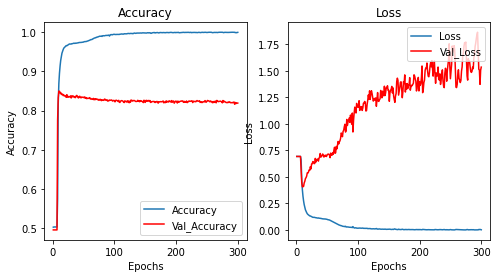

1532/1532 - 4s - loss: 0.4089 - accuracy: 0.8445
data loading from file..
original train_data:150000, test_data:50000
cleaned train_data:145860, test_data:48997

Success!
Train data sample : [1] 신카이 마코토의 작화와,미유와 하나카나가 연기를 잘해줘서 더대박이였다.
Test data sample : [0] 걸작은 몇안되고 졸작들만 넘쳐난다.

encoding..
Train data sample : [1]
	[177, 8642, 8301, 56, 8514, 8434, 8317, 6998, 8410, 8339, 8341, 8427, 8410, 211, 8642, 2713, 1235, 63, 8348, 2907, 67, 1821, 4414, 8300, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0]
	신카이 마코토의 작화와,미유와 하나카나가 연기를 잘해줘서 더대박이였다. ⁇  ⁇  ⁇  ⁇  ⁇  ⁇  ⁇  ⁇  ⁇  ⁇  ⁇  ⁇  ⁇  ⁇  ⁇  ⁇  ⁇  ⁇  ⁇  ⁇  ⁇  ⁇  ⁇  ⁇  ⁇  ⁇  ⁇  ⁇  ⁇  ⁇  ⁇  ⁇  ⁇  ⁇  ⁇  ⁇  ⁇  ⁇  ⁇  ⁇  ⁇  ⁇  ⁇  ⁇  ⁇  ⁇  ⁇  ⁇  ⁇  ⁇  ⁇  ⁇  ⁇  ⁇  ⁇  ⁇  ⁇  ⁇  ⁇  ⁇  ⁇  ⁇  ⁇  ⁇  ⁇  ⁇  ⁇  ⁇  ⁇  ⁇  ⁇  ⁇  ⁇  ⁇  ⁇  ⁇ 
Test data sample : [0]
	[1176, 8320, 455, 7994, 989

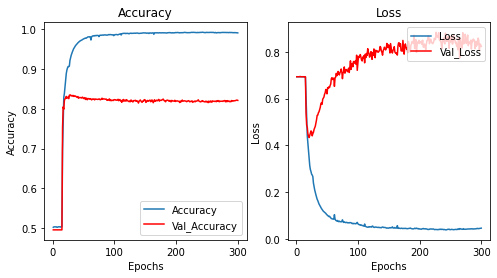

1532/1532 - 4s - loss: 0.4422 - accuracy: 0.8233
data loading from file..
original train_data:150000, test_data:50000
cleaned train_data:145860, test_data:48997

Success!
Train data sample : [1] 신카이 마코토의 작화와,미유와 하나카나가 연기를 잘해줘서 더대박이였다.
Test data sample : [0] 걸작은 몇안되고 졸작들만 넘쳐난다.

encoding..
Train data sample : [1]
	[177, 8642, 8301, 56, 8514, 8434, 8317, 6998, 8410, 8339, 8341, 8427, 8410, 211, 8642, 2713, 1235, 63, 8348, 2907, 67, 1821, 4414, 8300, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0]
	신카이 마코토의 작화와,미유와 하나카나가 연기를 잘해줘서 더대박이였다. ⁇  ⁇  ⁇  ⁇  ⁇  ⁇  ⁇  ⁇  ⁇  ⁇  ⁇  ⁇  ⁇  ⁇  ⁇  ⁇  ⁇  ⁇  ⁇  ⁇  ⁇  ⁇  ⁇  ⁇  ⁇  ⁇  ⁇  ⁇  ⁇  ⁇  ⁇  ⁇  ⁇  ⁇  ⁇  ⁇  ⁇  ⁇  ⁇  ⁇  ⁇  ⁇  ⁇  ⁇  ⁇  ⁇  ⁇  ⁇  ⁇  ⁇  ⁇  ⁇  ⁇  ⁇  ⁇  ⁇  ⁇  ⁇  ⁇  ⁇  ⁇  ⁇  ⁇  ⁇  ⁇  ⁇  ⁇  ⁇  ⁇  ⁇  ⁇  ⁇  ⁇  ⁇  ⁇  ⁇ 
Test data sample : [0]
	[1176, 8320, 455, 7994, 989

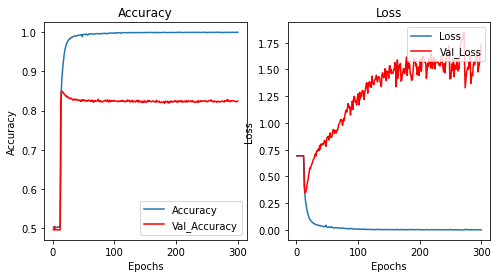

1532/1532 - 4s - loss: 0.3520 - accuracy: 0.8469
data loading from file..
original train_data:150000, test_data:50000
cleaned train_data:145860, test_data:48997

Success!
Train data sample : [1] 신카이 마코토의 작화와,미유와 하나카나가 연기를 잘해줘서 더대박이였다.
Test data sample : [0] 걸작은 몇안되고 졸작들만 넘쳐난다.

encoding..
Train data sample : [1]
	[177, 8642, 8301, 56, 8514, 8434, 8317, 6998, 8410, 8339, 8341, 8427, 8410, 211, 8642, 2713, 1235, 63, 8348, 2907, 67, 1821, 4414, 8300, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0]
	신카이 마코토의 작화와,미유와 하나카나가 연기를 잘해줘서 더대박이였다. ⁇  ⁇  ⁇  ⁇  ⁇  ⁇  ⁇  ⁇  ⁇  ⁇  ⁇  ⁇  ⁇  ⁇  ⁇  ⁇  ⁇  ⁇  ⁇  ⁇  ⁇  ⁇  ⁇  ⁇  ⁇  ⁇  ⁇  ⁇  ⁇  ⁇  ⁇  ⁇  ⁇  ⁇  ⁇  ⁇  ⁇  ⁇  ⁇  ⁇  ⁇  ⁇  ⁇  ⁇  ⁇  ⁇  ⁇  ⁇  ⁇  ⁇  ⁇  ⁇  ⁇  ⁇  ⁇  ⁇  ⁇  ⁇  ⁇  ⁇  ⁇  ⁇  ⁇  ⁇  ⁇  ⁇  ⁇  ⁇  ⁇  ⁇  ⁇  ⁇  ⁇  ⁇  ⁇  ⁇ 
Test data sample : [0]
	[1176, 8320, 455, 7994, 989

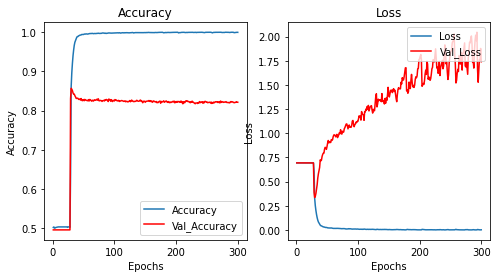

1532/1532 - 4s - loss: 0.3414 - accuracy: 0.8533


In [62]:
result_dict = {}
for tokenizer in tokenizers:
  X_train, y_train, X_test, y_test, word_index, index_word = load_data(sp_bpe_tokenizer)
  X_train, X_val, y_train, y_val = train_test_split(X_train, y_train, test_size=0.2, random_state=random_state)

  ckpt_path = "checkpoint.ckpt"
  checkpoint = create_checkpoint_callback(ckpt_path, verbos=0)

  model = create_lstm_model(vocab_size, word_vector_dim)
  model.compile(optimizer='adam',
              loss='binary_crossentropy',
              metrics=['accuracy'])

  history = model.fit(X_train,
                    y_train,
                    epochs=epochs,
                    batch_size=batch_size,
                    validation_data=(X_val, y_val),
                    verbose=0,
                    callbacks=[checkpoint])

  draw_history(history)

  model.load_weights(ckpt_path)
  results = model.evaluate(X_test,  y_test, verbose=2)

  result_dict[tokenizer.to_string()] = results

In [63]:
for key, value in result_dict.items():
  print(key, value)

SpaceBasedTokenizer [0.4088663160800934, 0.8444598913192749]
MorphsTokenizer [0.4422064423561096, 0.8232749104499817]
SentencePieceTokenizer-unigram [0.3519842326641083, 0.8469294309616089]
SentencePieceTokenizer-bpe [0.34144580364227295, 0.853256344795227]
